In [1]:
# importing libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

In [3]:
# create categories for duration 
bins = [0, 6, 12, 24, 24*7, float('inf')] 
labels = ['0-6 hr', '6-12 hr', '12-24 hr', '24hr-1wk', '1+wk']
df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, right=False)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ---  Select Features and Target
features = ['Region', 'NSP', 'Recall_Day_Hours', 'Recall_Night_Hours',
            'Project Work?', 'DNSP Aware?', 'Generator Aware?',
            'Inter-Regional', 'Asset Type', 'Reason']

X = df[features]
y = df['Duration_Category']

# --- Encode Categorical Variables
X = X.copy()
for col in ['Region', 'NSP', 'Asset Type', 'Reason']:
    X[col] = LabelEncoder().fit_transform(X[col])

# --- Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# --- Feature Importance
importances = clf.feature_importances_
feature_names = X.columns


In [5]:
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# import matplotlib.pyplot as plt

# def evaluate_rf_classifier(model, X_train, X_test, y_train, y_test, labels_order=['0-6 hr', '6-12 hr', '12-24 hr', '24hr-1wk', '1+wk']):
#     # Predict
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)
    
#     # Accuracy
#     train_acc = accuracy_score(y_train, y_train_pred)
#     test_acc = accuracy_score(y_test, y_test_pred)
    
#     # --- 1. Classification Report
#     print("Classification Report (Test Set):")
#     print(classification_report(y_test, y_test_pred, target_names=labels_order))

#     # --- 2. Setup figure for all plots
#     fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
#     # --- 3. Feature Importances
#     importances = model.feature_importances_
#     indices = np.argsort(importances)[::-1]
#     feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'feature_{i}' for i in range(X_train.shape[1])]
    
#     axes[0].barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
#     axes[0].invert_yaxis()
#     axes[0].set_title("Feature Importances")
#     axes[0].set_xlabel("Importance")

#     # --- 4. Confusion Matrices
#     cm_train = confusion_matrix(y_train, y_train_pred, labels=labels_order)
#     cm_test = confusion_matrix(y_test, y_test_pred, labels=labels_order)

#     disp_train = ConfusionMatrixDisplay(cm_train, display_labels=labels_order)
#     disp_train.plot(ax=axes[1], cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
#     axes[1].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

#     disp_test = ConfusionMatrixDisplay(cm_test, display_labels=labels_order)
#     disp_test.plot(ax=axes[2], cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
#     axes[2].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

#     plt.tight_layout()
#     plt.show()

In [6]:
# evaluate_rf_classifier(clf, X_train, X_test, y_train, y_test)

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt

def train_and_evaluate_rf(df, train_model=True, model=None, test_size=0.2, random_state=42):
    """
    Trains and/or evaluates a Random Forest classifier using the specified DataFrame.
    Automatically adapts to the number of classes present.
    """

    # --- 1. Select Features and Target
    features = ['Region', 'NSP', 'Recall_Day_Hours', 'Recall_Night_Hours',
                'Project Work?', 'DNSP Aware?', 'Generator Aware?',
                'Inter-Regional', 'Asset Type', 'Reason']
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    if train_model or model is None:
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train, y_train)

    # --- 5. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 6. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 7. Get present labels (classes that actually exist)
    present_labels = sorted(y_test.unique())

    # --- 8. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

    # --- 9. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Feature Importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

    axes[0].barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    axes[0].invert_yaxis()
    axes[0].set_title("Feature Importances")
    axes[0].set_xlabel("Importance")

    # Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
    disp_train.plot(ax=axes[1], cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    axes[1].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
    disp_test.plot(ax=axes[2], cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    axes[2].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

    plt.tight_layout()
    plt.show()

    return model  # Return model for possible reuse

Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.54      0.43      0.48        30
        1+wk       0.47      0.32      0.38        25
    12-24 hr       0.70      0.60      0.65       115
    24hr-1wk       0.82      0.78      0.80        94
     6-12 hr       0.68      0.81      0.74       202

    accuracy                           0.70       466
   macro avg       0.64      0.59      0.61       466
weighted avg       0.70      0.70      0.69       466



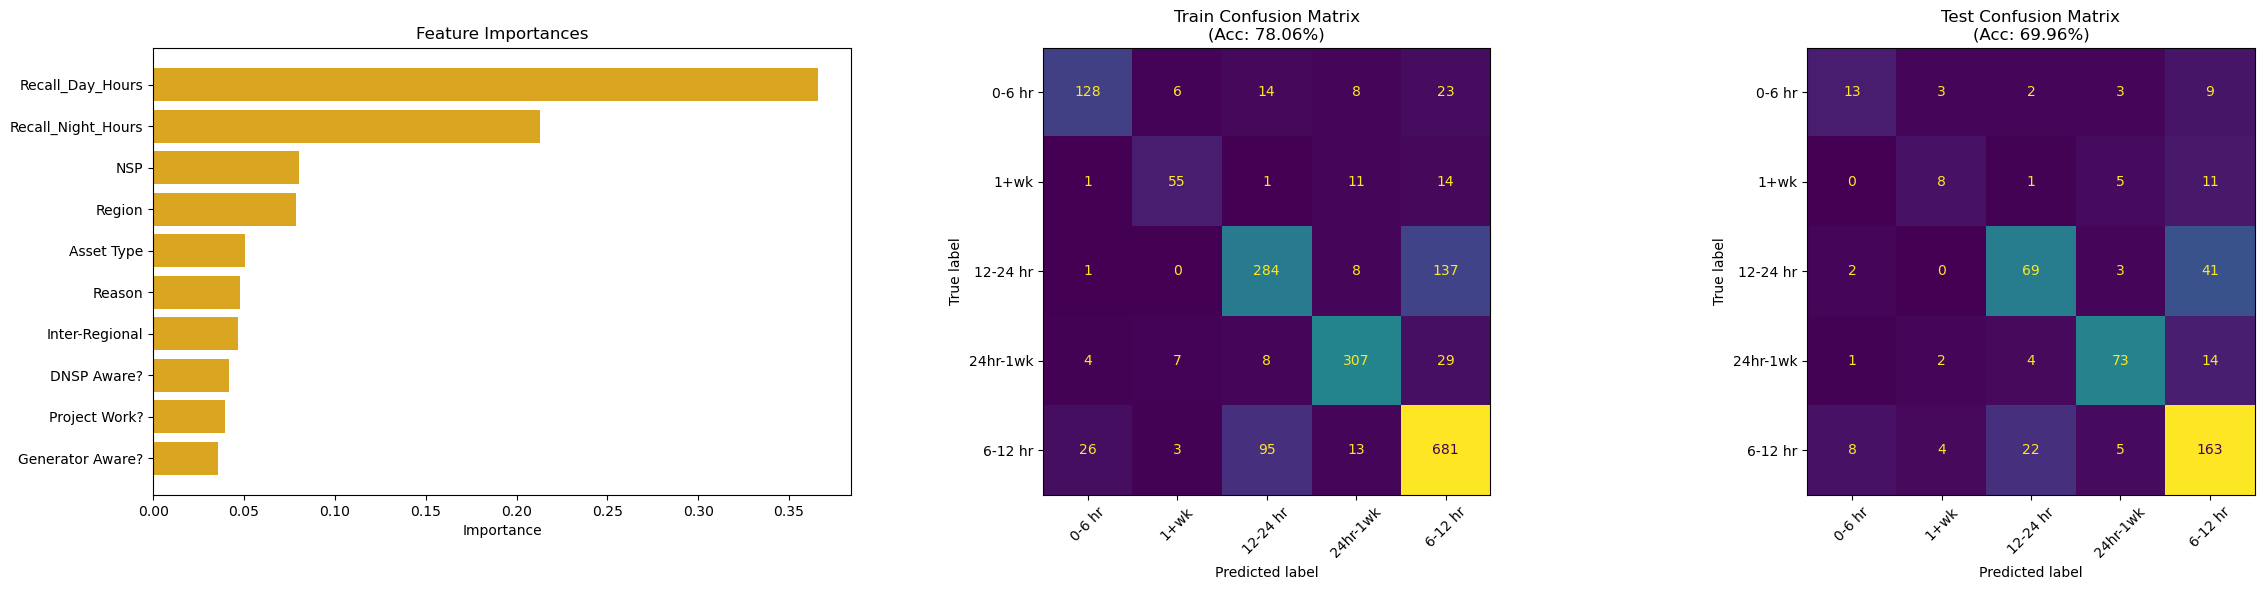

In [11]:
model = train_and_evaluate_rf(df)

--- Region: SA ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.50      0.33      0.40        12
        1+wk       1.00      0.33      0.50         3
    12-24 hr       0.67      0.67      0.67         3
    24hr-1wk       0.80      0.94      0.87        35
     6-12 hr       0.40      0.40      0.40         5

    accuracy                           0.72        58
   macro avg       0.67      0.54      0.57        58
weighted avg       0.71      0.72      0.70        58



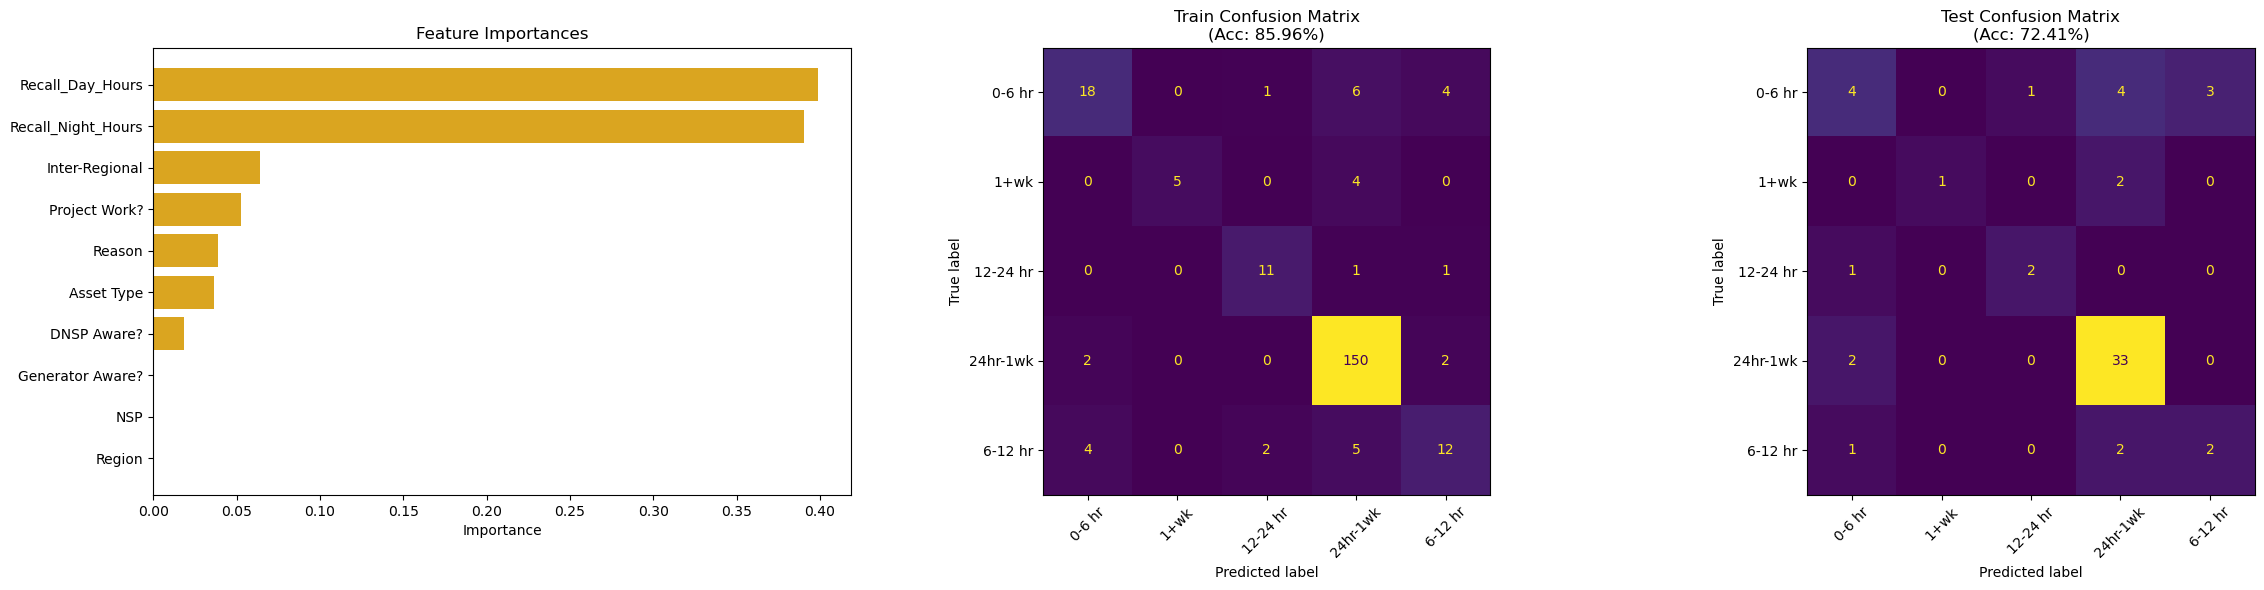

--- Region: VIC ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.80      0.40      0.53        10
        1+wk       1.00      1.00      1.00         2
    12-24 hr       0.67      0.78      0.72       101
    24hr-1wk       1.00      0.44      0.61        16
     6-12 hr       0.74      0.72      0.73       122

    accuracy                           0.72       251
   macro avg       0.84      0.67      0.72       251
weighted avg       0.73      0.72      0.71       251



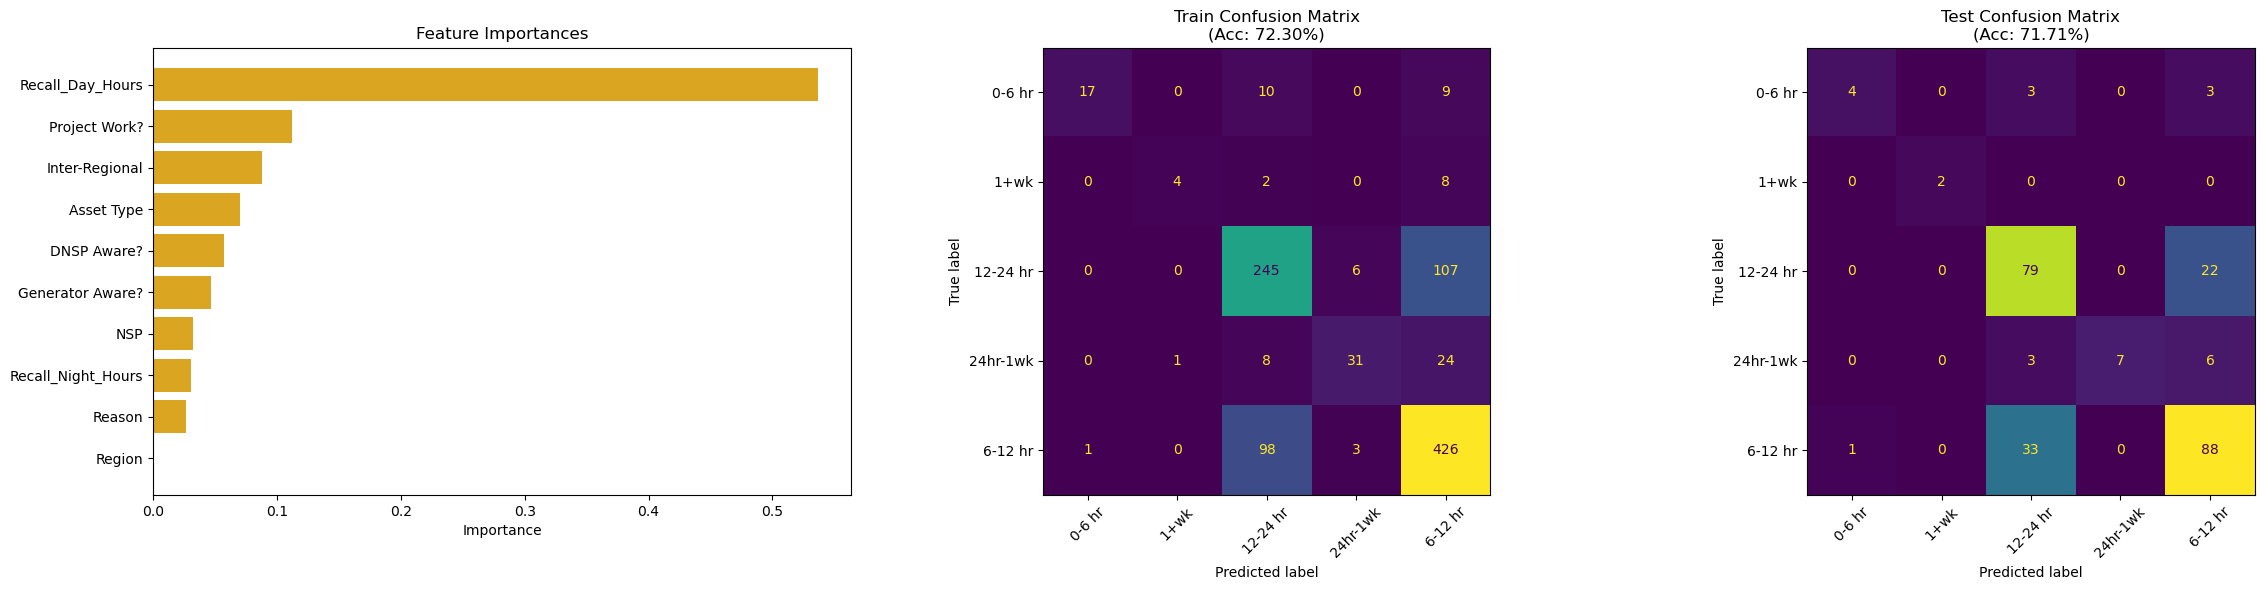

--- Region: TAS ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       1.00      0.78      0.88         9
        1+wk       1.00      0.50      0.67         2
    24hr-1wk       1.00      0.67      0.80         9
     6-12 hr       0.60      1.00      0.75         9

    accuracy                           0.79        29
   macro avg       0.90      0.74      0.77        29
weighted avg       0.88      0.79      0.80        29



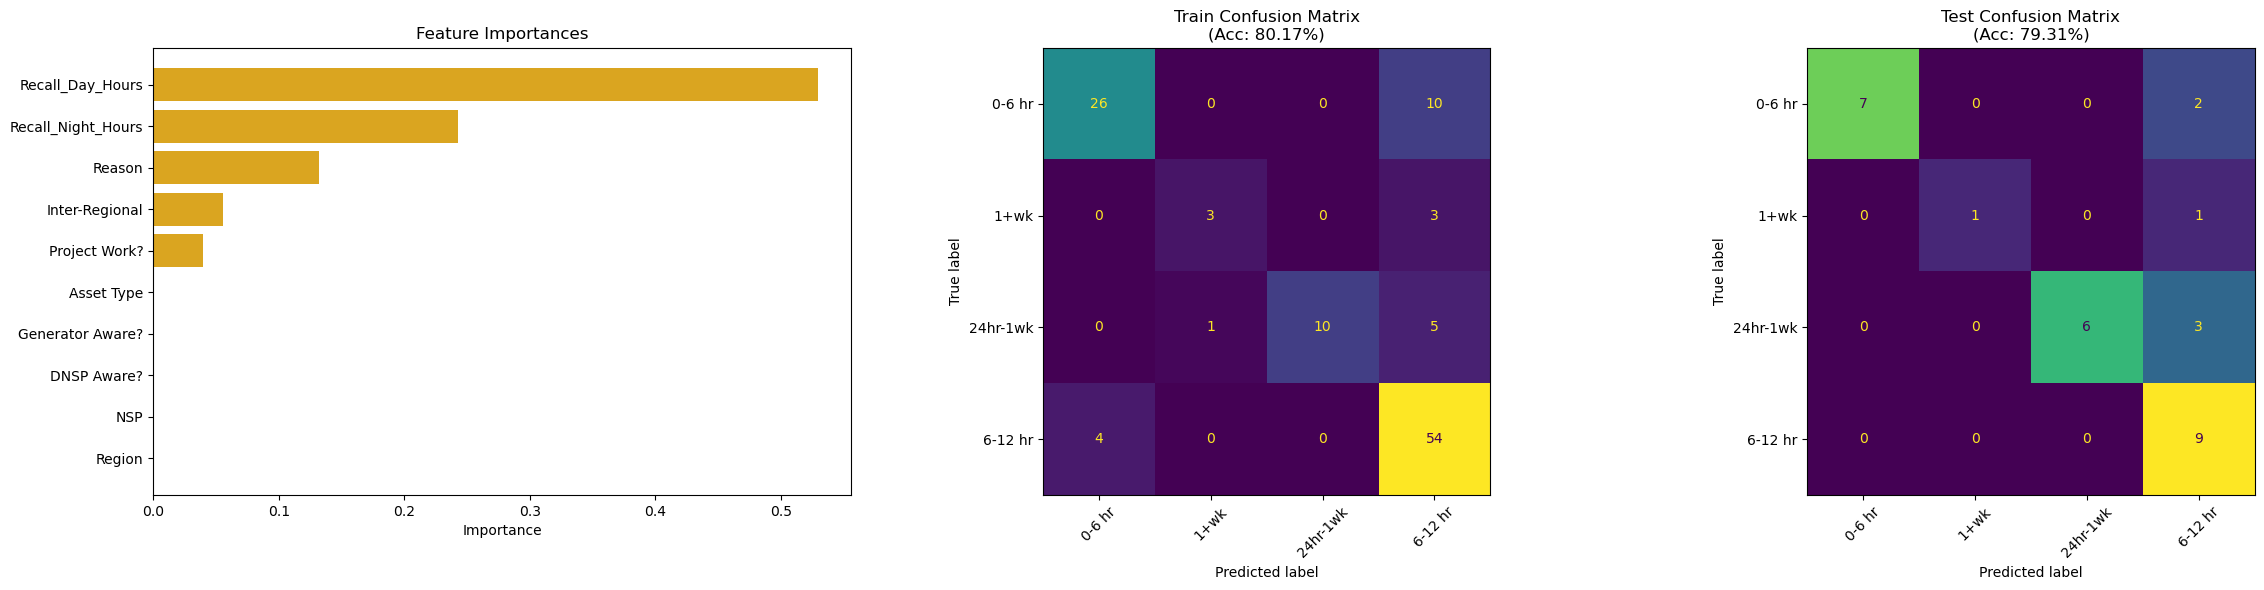

--- Region: QLD ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.73      0.80      0.76        10
        1+wk       0.61      0.92      0.73        12
    24hr-1wk       0.85      0.85      0.85        20
     6-12 hr       0.96      0.76      0.85        34

    accuracy                           0.82        76
   macro avg       0.79      0.83      0.80        76
weighted avg       0.85      0.82      0.82        76



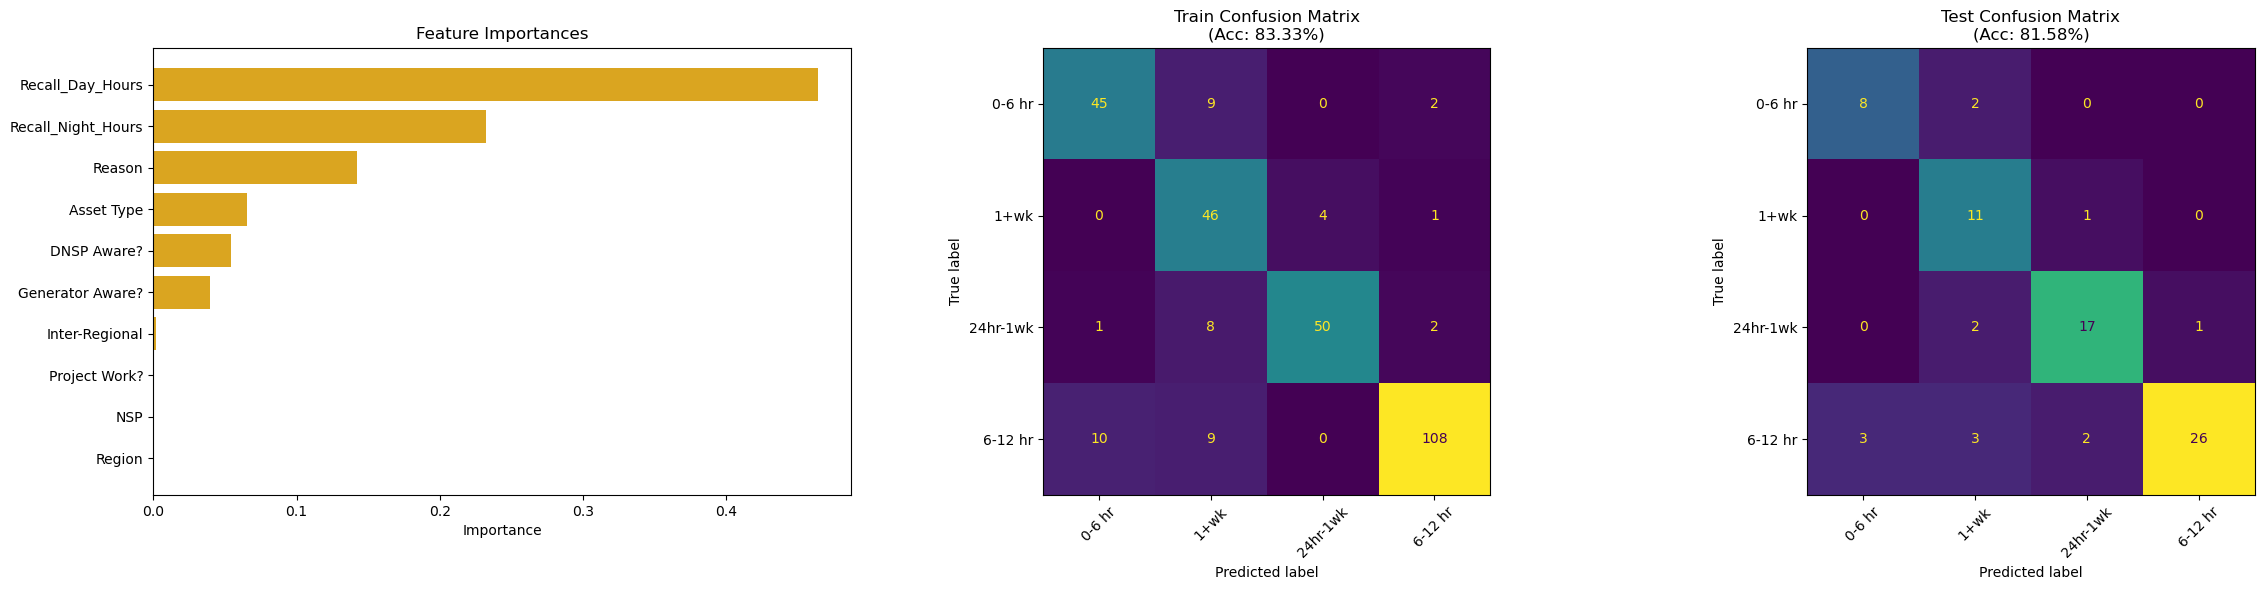

--- Region: NSW ---
Classification Report (Test Set):
              precision    recall  f1-score   support

      0-6 hr       0.67      0.67      0.67         3
        1+wk       0.50      1.00      0.67         1
    12-24 hr       0.50      0.44      0.47         9
    24hr-1wk       0.86      0.82      0.84        22
     6-12 hr       0.76      0.80      0.78        20

    accuracy                           0.75        55
   macro avg       0.66      0.75      0.68        55
weighted avg       0.75      0.75      0.74        55



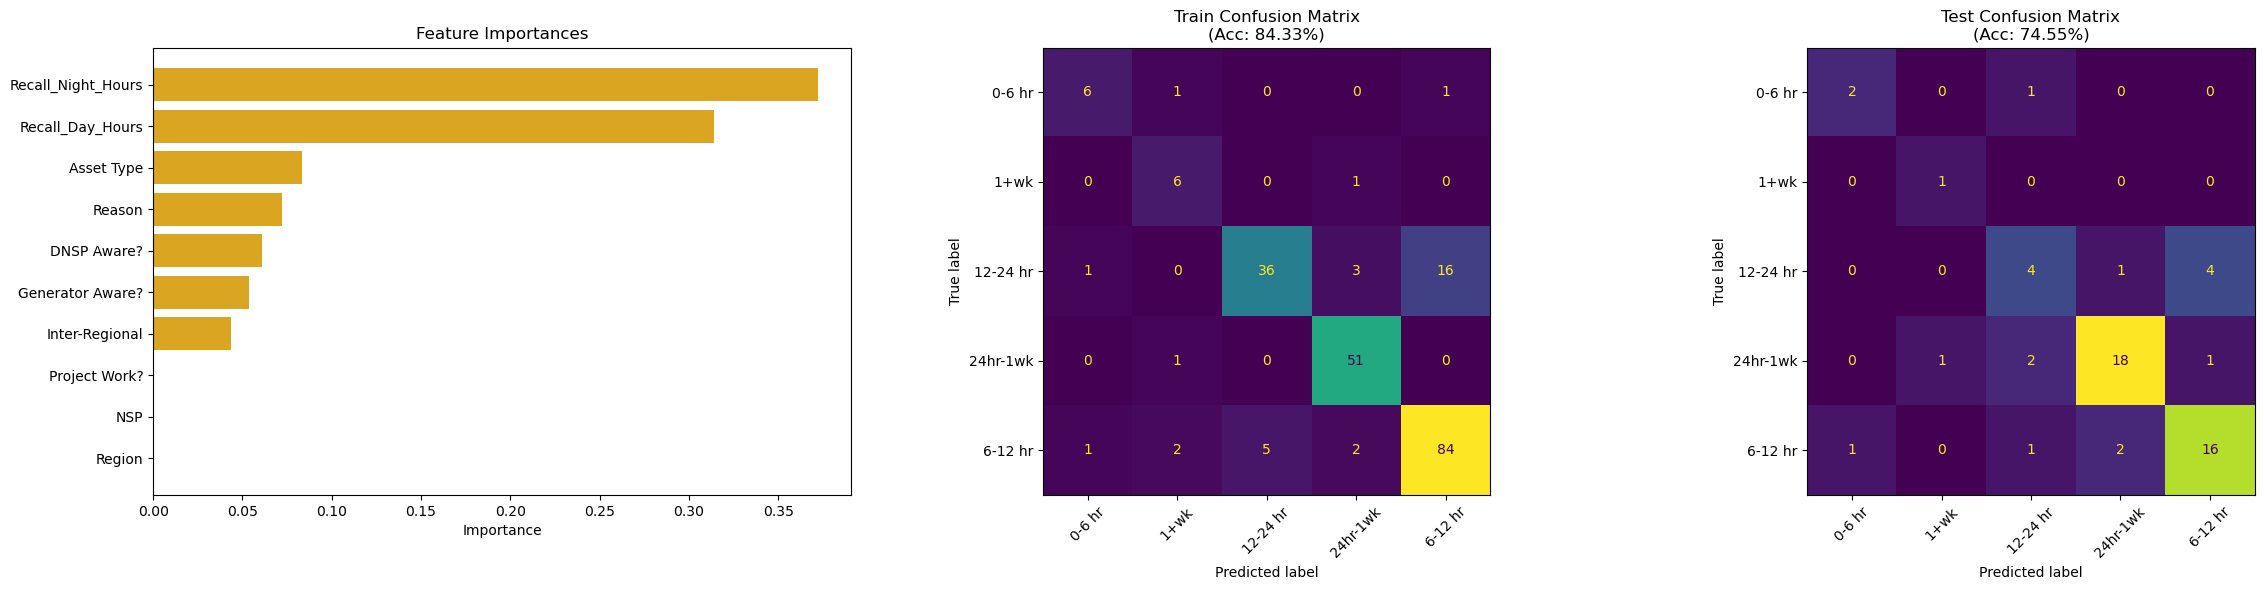

In [13]:
region_models = {}
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"--- Region: {region} ---")
    model = train_and_evaluate_rf(region_df)
    region_models[region] = model
